In [1]:
import numpy as np
import json
from utilities import *
from utilitiesDL import *
from OFDMparam import *
from CFOcorr import *
from getModFeat import *
import random
import os
from glob import glob
from collections import defaultdict

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
pi = math.pi

/home/byk004/miniconda3/envs/cyclo_modul_OFDM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
imgSize = 50
coord = 'sph'

SNRVec = np.arange(5, 46, 5, dtype=int)
lowestMod = '16qam' # {psk, 16qam, 64qam, test}

samplingRate = 20e6
longestPreambleLen = 1200
wlanHTInputSym = 40
wlanHEInputSym = 10
removeNull = True
if lowestMod == 'test' or lowestMod == 'psk':
    angleMod = False
else:
    angleMod = True

f = open('./inputJson/test.json')
dataPath = json.load(f)['data_path']
print(dataPath)

f = open('./inputJson/class/testClass.json')
classJson = json.load(f)
protocolList = np.array(classJson['protocolList'])
CPOptList = np.array(classJson['CPOptList'], dtype=object)
CPLenList = np.array(classJson['CPLenList'], dtype=object)
modList = np.array(classJson['modList'], dtype=object)

/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/16qam/


In [3]:
def imgData(audio_input, imgSize, angleMod):
    horIndex = np.ceil(np.abs(audio_input) / (np.max(np.abs(audio_input)) / imgSize)).reshape(-1, 1)
    if angleMod:
        verIndex = np.ceil(np.angle(audio_input) / ((pi/2) / imgSize)).reshape(-1, 1)
    else:
        verIndex = np.ceil(np.angle(audio_input) / (pi / imgSize)).reshape(-1, 1)
    horIndex[horIndex == imgSize] = imgSize-1
    verIndex[verIndex == imgSize] = imgSize-1
        
    horIndexIndicator = np.reshape(np.arange(imgSize), (-1, 1)) ==\
        np.reshape(horIndex, (1, 1, np.size(horIndex)))
    if angleMod:
        verIndexIndicator = np.transpose(np.reshape(np.arange(imgSize), (-1, 1)) ==\
            (np.reshape(verIndex, (1, 1, np.size(verIndex)))), (1,0,2))
    else:
        verIndexIndicator = np.transpose(np.reshape(np.arange((-imgSize+1), (imgSize+1), 2), (-1, 1)) ==\
            (np.reshape(verIndex, (1, 1, np.size(verIndex)))), (1,0,2))
    # print(horIndexIndicator.shape, verIndexIndicator.shape)

    Input = np.expand_dims(np.sum(horIndexIndicator * verIndexIndicator, axis=2).astype(float), 0)
    # print(Input.shape)
    return Input

In [4]:
dataDict = {file:[] for file in protocolList}
for i, protocol in enumerate(protocolList):
    dataDict[protocol] = {file:[] for file in CPOptList[i]}
    for CPOpt in CPOptList[i]:
        dataDict[protocol][CPOpt] = {file:[] for file in modList[i]}
        for mod in modList[i]:
            dataDict[protocol][CPOpt][mod] = {file:[] for file in SNRVec}
            for SNR in SNRVec:
                dataDict[protocol][CPOpt][mod][SNR] = defaultdict(list)

for subFolder in os.walk(dataPath):
    dirFilenameList = glob(subFolder[0] + '/*.32cf')
    print(len(dirFilenameList))
    for fileIndex, dirFileName in enumerate(dirFilenameList):
        fileName = dirFileName.split("/")[-1][:-5]
        fileProtocol = (dirFileName.split("/")[-1][:-5]).split("_")[0]
        fileCPOpt = (dirFileName.split("/")[-1][:-5]).split("_")[1]
        fileMod = int((dirFileName.split("/")[-1][:-5]).split("_")[2])
        fileSNR = int((dirFileName.split("/")[-1][:-5]).split("_")[4])
        
        fileProtocolIndex = int(np.where(protocolList == fileProtocol)[0])
        fileModIndex = int(np.where(np.array(modList[fileProtocolIndex]) == fileMod)[0])
        if lowestMod == 'psk':
            if fileModIndex > 2:
                fileModIndex = 2
        elif lowestMod == '16qam':
            if fileModIndex > 3:
                fileModIndex = 3
            fileModIndex -= 2
        elif lowestMod == '64qam':
            if fileModIndex > 4:
                fileModIndex = 4
            fileModIndex -= 3

        dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['label'].append(fileModIndex)
        load_out = np.fromfile(dirFileName, dtype=np.float32)
        data = load_out[np.arange(0, load_out.shape[0], 2)] +\
            1j * load_out[np.arange(1, load_out.shape[0], 2)]

        if fileProtocol == 'wlanHT':
            nSubC = 64
            if fileCPOpt == 'Normal':
                CPLen = 8
            else:
                CPLen = 16
            preambleLen = 720
            inputLen = (wlanHTInputSym+2) * (nSubC+CPLen)
            nSym = wlanHTInputSym
        elif fileProtocol == 'wlanHE':
            nSubC = 256
            if fileCPOpt == 'Normal':
                CPLen = 16
                preambleLen = 1152
            elif fileCPOpt == 'Medium':
                CPLen = 32
                preambleLen = 1040
            else:
                CPLen = 64
                preambleLen = 1200  
            inputLen = (wlanHEInputSym+2) * (nSubC+CPLen)
            nSym = wlanHEInputSym

        inputStartIndex = int(random.randint(longestPreambleLen, data.shape[0]-inputLen))
        firstIndexTruth = (-1 * inputStartIndex + preambleLen) % (nSubC+CPLen)
        inputIQ_CFO = corrCFO(data[inputStartIndex : inputStartIndex+inputLen],\
            nSubC, CPLen, firstIndexTruth, samplingRate, 2)
        feat = getModFeat(inputIQ_CFO, nSubC, CPLen, firstIndexTruth, nSym, removeNull, angleMod)
        feat = np.reshape(feat, (56, 40))
        
        # print('img, ', imgData(feat, imgSize, angleMod).shape)
        dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(imgData(feat, imgSize, angleMod))

        
for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for mod in modList[i]:
            numFile = 0
            for SNR in SNRVec:
                numFile += len(dataDict[protocol][CPOpt][mod][SNR]['label'])
            print(protocol, CPOpt, str(mod), numFile)

0
450
450
450
450
450
450
450
450
450
450
450
450
wlanHT Extended 2 0
wlanHT Extended 4 0
wlanHT Extended 16 0
wlanHT Extended 64 0
wlanHT Normal 2 0
wlanHT Normal 4 0
wlanHT Normal 16 0
wlanHT Normal 64 0
wlanHE Extended 2 0
wlanHE Extended 4 0
wlanHE Extended 16 450
wlanHE Extended 64 450
wlanHE Extended 256 450
wlanHE Extended 1024 450
wlanHE Medium 2 0
wlanHE Medium 4 0
wlanHE Medium 16 450
wlanHE Medium 64 450
wlanHE Medium 256 450
wlanHE Medium 1024 450
wlanHE Normal 2 0
wlanHE Normal 4 0
wlanHE Normal 16 450
wlanHE Normal 64 450
wlanHE Normal 256 450
wlanHE Normal 1024 450
NRDLa Extended 4 0
NRDLa Extended 16 0
NRDLa Extended 64 0
NRDLa Extended 256 0
NRDLa Normal 4 0
NRDLa Normal 16 0
NRDLa Normal 64 0
NRDLa Normal 256 0
NRDLb Normal 4 0
NRDLb Normal 16 0
NRDLb Normal 64 0
NRDLb Normal 256 0
NRDLc Normal 4 0
NRDLc Normal 16 0
NRDLc Normal 64 0
NRDLc Normal 256 0


(50, 50)


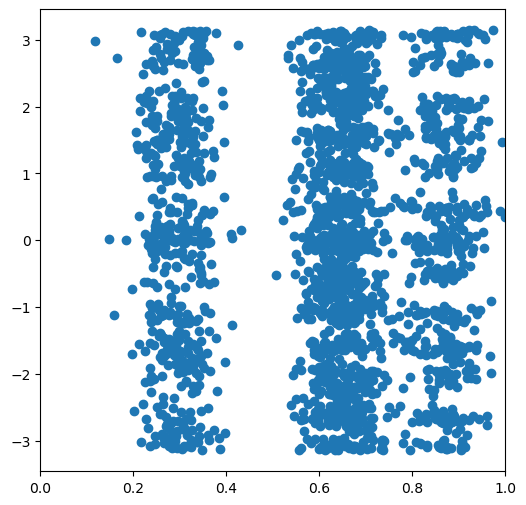

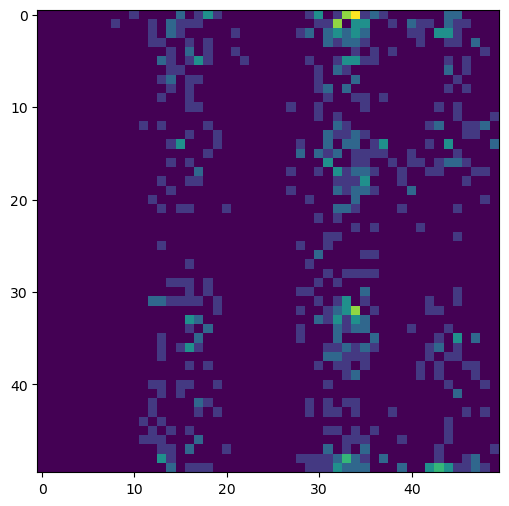

In [5]:
# dataDict['wlanHT']['Extended'][4][30]['input'][0][0, :, :].flatten().shape
# print(feat)
dirFileName = '/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHE/wlanHE_Extended_16qam/wlanHE_Extended_16_0_20_20_0.4_24.32cf'
dirMetadataFile = open('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHE/wlanHE_Extended_16qam/wlanHE_Extended_16_0_20_20_0.4_24.metadata')
loadMetadata = json.load(dirMetadataFile)

# print(dirFileName)
load_out = np.fromfile(dirFileName, dtype=np.float32)
data = load_out[np.arange(0, load_out.shape[0], 2)] +\
    1j * load_out[np.arange(1, load_out.shape[0], 2)]
# print(data.shape[0])

preambleLen = 1200
nSubC = 256
CPLen = 64
nSym = 10
inputLen = (wlanHEInputSym+2) * (nSubC+CPLen)
inputStartIndex = int(random.randint(longestPreambleLen, data.shape[0]-inputLen))

inputIQ = data[inputStartIndex:inputStartIndex+inputLen]
firstIndexTruth = (-1 * inputStartIndex + preambleLen) % (nSubC+CPLen)
# print(inputIQ.shape[0], inputStartIndex, firstIndexTruth)

CFOtruth = getCFOtruth(loadMetadata)
# print(CFOtruth)
# print(estCFO(inputIQ, nSubC, CPLen, firstIndexTruth, samplingRate))

inputIQ_CFOest = corrCFO(inputIQ, nSubC, CPLen, firstIndexTruth, samplingRate, 2)
feat = getModFeat(inputIQ_CFOest, nSubC, CPLen, firstIndexTruth, nSym, removeNull, False)
imgDataResult = np.squeeze(imgData(feat, imgSize, angleMod))
print(imgDataResult.shape)

feat = torch.from_numpy(feat)

plt.figure(figsize=(6,6))
plt.scatter(torch.divide(torch.abs(feat), torch.max(torch.abs(feat))), torch.angle(feat))
plt.xlim(0, 1)

plt.figure(figsize=(6,6))
plt.imshow(imgDataResult)
# print(horIndexIndicator.shape, verIndexIndicator.shape)
# print(np.max(horIndex), np.max(verIndex), np.min(horIndex), np.min(verIndex))
# print(imgInput.shape, absMax)
# xylim = 0.06
# plt.xlim((-xylim, xylim))
# plt.ylim((-xylim, xylim))

In [6]:
trList = list()
valList = list()
cudaID = 0
batchSize = 32
# trainSNRVec = range(5, 41, 5)
# trainSNRVec = [0, 0, 15, 25, 30, 40]
# trainSNRVec = [0, 0, 0, 0, 0, 0]
SNRThres = 20
trainSNRVec = [SNRThres, SNRThres, SNRThres, SNRThres, SNRThres, SNRThres]

for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for iMod, mod in enumerate(modList[i]):
            trDataCount = 0
            valDataCount = 0
            for SNR in SNRVec:
                # dataset = sphDataset(dataDict[protocol][CPOpt][mod][SNR],cuda_id=cudaID)
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR], imgSize, angleMod, cuda_id=cudaID)

                if iMod >= 10:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label']) / 2))
                    numTotData = int(np.ceil(len(dataDict[protocol][CPOpt][mod][SNR]['label'] ) / 2))
                else:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                    numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                if SNR >= trainSNRVec[iMod]:
                    # print(SNR, trainSNRVec[iMod])
                    trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                    valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                # valDataCount += (numTotData - numTrData)

                if SNR < trainSNRVec[iMod]:
                    numTrData = 0
                    numTotData = 0
                # print(protocol, CPOpt, str(mod), numTrData, numTotData)
                trDataCount += numTrData
                valDataCount += (numTotData - numTrData)

            print(protocol, CPOpt, str(mod), trDataCount, valDataCount)

trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
valDataset = torch.utils.data.ConcatDataset(valList)

trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

print('Training data size: '+str(len(trDataset))+' Test data size: '+str(len(valDataset)))

wlanHT Extended 2 0 0
wlanHT Extended 4 0 0
wlanHT Extended 16 0 0
wlanHT Extended 64 0 0
wlanHT Normal 2 0 0
wlanHT Normal 4 0 0
wlanHT Normal 16 0 0
wlanHT Normal 64 0 0
wlanHE Extended 2 0 0
wlanHE Extended 4 0 0
wlanHE Extended 16 240 60
wlanHE Extended 64 240 60
wlanHE Extended 256 240 60
wlanHE Extended 1024 240 60
wlanHE Medium 2 0 0
wlanHE Medium 4 0 0
wlanHE Medium 16 240 60
wlanHE Medium 64 240 60
wlanHE Medium 256 240 60
wlanHE Medium 1024 240 60
wlanHE Normal 2 0 0
wlanHE Normal 4 0 0
wlanHE Normal 16 240 60
wlanHE Normal 64 240 60
wlanHE Normal 256 240 60
wlanHE Normal 1024 240 60
NRDLa Extended 4 0 0
NRDLa Extended 16 0 0
NRDLa Extended 64 0 0
NRDLa Extended 256 0 0
NRDLa Normal 4 0 0
NRDLa Normal 16 0 0
NRDLa Normal 64 0 0
NRDLa Normal 256 0 0
NRDLb Normal 4 0 0
NRDLb Normal 16 0 0
NRDLb Normal 64 0 0
NRDLb Normal 256 0 0
NRDLc Normal 4 0 0
NRDLc Normal 16 0 0
NRDLc Normal 64 0 0
NRDLc Normal 256 0 0
Training data size: 2880 Test data size: 720


In [7]:
nClass = 3
inputSym = 40
LR = 5e-4
criterion = torch.nn.CrossEntropyLoss()

savePskModelPath = './saveDLModel/wifiHEImgPskWo45.cpkt'
save16QamModelPath = './saveDLModel/wifiHE16QamWo20.cpkt'
save64QamModelPath = './saveDLModel/wifiHE64QamW45.cpkt'

if lowestMod == 'psk':
    loadedWifiNet = wifiImgPskNet(nClass, removeNull)
elif lowestMod == '16qam':
    loadedWifiNet = wifiImg16QamNet(nClass, removeNull)
# elif lowestMod == '64qam':
#     loadedWifiNet = wifi64QamNet(nClass, removeNull)
# else:
loadedWifiNet.apply(init_weights)

if cudaID is not None: loadedWifiNet = loadedWifiNet.cuda(cudaID)

opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
loadedWifiNet.train()   # setting training flag


wifi16QamNet(
  (conv1): Conv2d(2, 4, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=12288, out_features=2400, bias=True)
  (fc2): Linear(in_features=2400, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [19]:
accTrainList = []
accValidList = []
bestAcc = 0.0
patience = 0
fastConvergeFlag = True
nEpoch = 150

if lowestMod == 'psk':
    saveModelPath = savePskModelPath
elif lowestMod == '16qam':
    saveModelPath = save16QamModelPath
elif lowestMod == '64qam':
    saveModelPath = save64QamModelPath
print('save model path:', saveModelPath)
torch.set_num_threads(1)
for epoch in range(nEpoch):
    runningLoss = 0.0
    for i, data in enumerate(trLoader):
        # print('train:', i)
        targets = data['target']
        opt.zero_grad()
        trInput = data['input']
        # print(data['input'].shape)

        outputs = loadedWifiNet(trInput)
        loss = criterion(outputs, targets)
        # print('backprop')
        loss.backward()
        opt.step()
        runningLoss += loss.item()

    avgLoss = runningLoss/len(trLoader)
    accTrain = getAcc(trLoader, loadedWifiNet)
    print('epoch: ', epoch, 'train loss: ', round(avgLoss, 4),\
        'accuracy: ', round(accTrain, 4))
    
    # getting valid error
    runningLoss = 0.0
    for i, data in enumerate(valLoader):
        # print('valid:', i)
        labels = data['target']
        validInput = data['input']

        outputs = loadedWifiNet(validInput)
        valLoss = criterion(outputs, labels)
        runningLoss += valLoss.item()

    avgValLoss = runningLoss/len(valLoader)
    accValid = getAcc(valLoader, loadedWifiNet)
    pred_l,target_l = getPreds(valLoader, loadedWifiNet)

    if bestAcc < accValid:
        bestAcc = accValid
        print('saving model')
        torch.save(loadedWifiNet.state_dict(), saveModelPath)  # saving model with best test accuracy
        patience = 0
        
    print('test loss: ', round(avgValLoss, 4), 'test accuracy:', round(accValid, 4))

    accTrainList.append(accTrain)
    accValidList.append(accValid)
    
    # early stopping if the model converges twice
    patience += 1
    if patience > 20:
        if fastConvergeFlag == True:
            LR = LR/10
            opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
            fastConvergeFlag = False
            patience = 0
            print('Fast Converge finishes!')
        else:
            break

print('best test accuracy:', round(bestAcc, 4))

save model path: ./saveDLModel/wifiHEImgPskWo45.cpkt
epoch:  0 train loss:  0.3428 accuracy:  0.9514
saving model
test loss:  0.1837 test accuracy: 0.9537
epoch:  1 train loss:  0.1398 accuracy:  0.9731
saving model
test loss:  0.107 test accuracy: 0.971
epoch:  2 train loss:  0.1008 accuracy:  0.9733
saving model
test loss:  0.0932 test accuracy: 0.9716
epoch:  3 train loss:  0.0879 accuracy:  0.9762
saving model
test loss:  0.0803 test accuracy: 0.9747
epoch:  4 train loss:  0.0814 accuracy:  0.9781
saving model
test loss:  0.0746 test accuracy: 0.9772
epoch:  5 train loss:  0.0762 accuracy:  0.9804
saving model
test loss:  0.0751 test accuracy: 0.9821
epoch:  6 train loss:  0.0755 accuracy:  0.979
test loss:  0.0684 test accuracy: 0.9784
epoch:  7 train loss:  0.0708 accuracy:  0.9801
test loss:  0.0655 test accuracy: 0.9784
epoch:  8 train loss:  0.0691 accuracy:  0.9809
test loss:  0.0594 test accuracy: 0.9821
epoch:  9 train loss:  0.0671 accuracy:  0.983
test loss:  0.0626 test 

In [20]:
# print(nClass)
cudaID = 0
batchSize = 32
loadedWifiPskNet = wifiImgPskNet(3, removeNull)
loadedWifi16QamNet = wifi16QamNet(2, removeNull)
# loadedWifi64QamNet = wifi64QamNet(2, removeNull)

if cudaID is not None: loadedWifiPskNet = loadedWifiPskNet.cuda(cudaID)
if cudaID is not None: loadedWifi16QamNet = loadedWifi16QamNet.cuda(cudaID)
# if cudaID is not None: loadedWifi64QamNet = loadedWifi64QamNet.cuda(cudaID)

savePskModelPath = './saveDLModel/wifiHEImgPskWo35.cpkt'
save16QamModelPath = './saveDLModel/wifiHE16QamWo20.cpkt'
save64QamModelPath = './saveDLModel/wifiHE64QamW45.cpkt'

# path for saving model
testSNRVec = range(5, 46, 5)
loadedWifiPskNet.load_state_dict(torch.load(savePskModelPath))
loadedWifi16QamNet.load_state_dict(torch.load(save16QamModelPath))
# loadedWifi64QamNet.load_state_dict(torch.load(save64QamModelPath))

for SNR in testSNRVec:
    trList = list()
    valList = list()

    for i, protocol in enumerate(protocolList):
        for CPOpt in CPOptList[i]:
            for mod in modList[i]:
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR],imgSize, angleMod, cuda_id=cudaID)
                
                numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                # print(protocol, CPOpt, str(mod), numTrData, numTotData)                
                trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                
    trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
    valDataset = torch.utils.data.ConcatDataset(valList)

    trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
    valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

    print(len(trDataset), len(valDataset))
    accTest = getAcc(valLoader, loadedWifiPskNet)
    # accTest = getAccWifi(valLoader, loadedWifiPskNet, loadedWifi64QamNet)

    print(SNR, accTest)

720 180
5 0.9555555555555556
720 180
10 0.9944444444444445
720 180
15 0.9944444444444445
720 180
20 1.0
720 180
25 1.0
720 180
30 1.0
720 180
35 1.0
720 180
40 0.9833333333333333
720 180
45 0.9944444444444445


[Text(0, 0, 'BPSK'), Text(0, 1, 'QPSK'), Text(0, 2, 'QAM')]

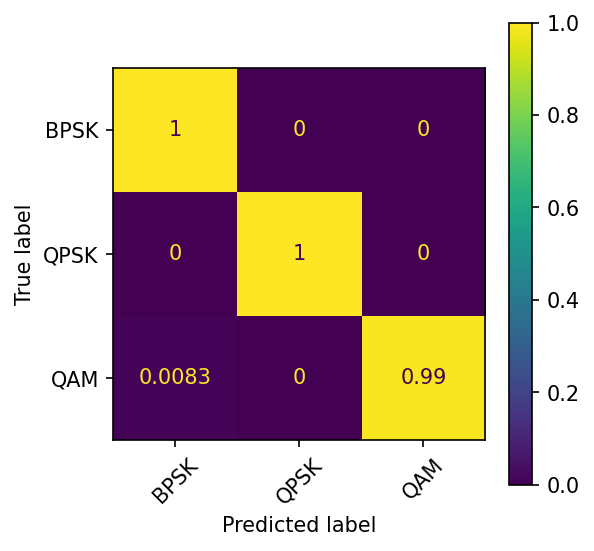

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# pred, target = getPredsWifi(valLoader, loadedWifiPskNet, loadedWifi16QamNet)
# print(pred, target)
pred, target = getPreds(valLoader, loadedWifiPskNet)

# font = {'size'   : 15}
# plt.rc('font', **font)

cm = confusion_matrix(target,pred,normalize ='true')
for i in range(2):
    for j in range(2):
        cm[i, j] = round(cm[i, j], 2)

# cm[2, 0] = round(cm[2, 0], 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

modNameList = []
for mod in modList[1]:        
    if mod == 2:
        # continue
        modul_name = 'BPSK'
    elif mod == 4:
        # continue
        modul_name = 'QPSK'
    elif mod == 16:
        # continue
        modul_name = 'QAM'
    elif mod == 64:
        break
        modul_name = '64QAM'
    elif mod == 256:
        # break
        modul_name = '256QAM'
    elif mod == 1024:
        break
        modul_name = '1024QAM'

    modNameList.append(modul_name)
plt_labels = modNameList
ax.set_xticklabels(plt_labels, rotation=45)
ax.set_yticklabels(plt_labels)

In [29]:
SNRVec = np.arange(40, 41, 2, dtype=int)
FFTsize = 4096
tauVec = np.array([64, 256, 512, 1024, 2048])
CPLenList = [[16, 8], [64, 32, 16], [128, 36], [72], [144]]
CPOptList = np.array([np.array(['Extended', 'Normal']),\
    np.array(['Extended', 'Medium', 'Normal']),\
    np.array(['Extended', 'Normal']),\
    np.array(['Normal']), np.array(['Normal'])], dtype=object)
protocolList = np.array(['wlanHT', 'wlanHE', 'NRDLa', 'NRDLb', 'NRDLc'])

In [50]:
load_out = np.fromfile('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.32cf',\
    dtype=np.float32)
f = open('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.metadata')
loadMetadata = json.load(f)

data = load_out[np.arange(0, load_out.shape[0], 2)] +\
                    1j * load_out[np.arange(1, load_out.shape[0], 2)]

In [26]:
from torchsummary import summary
summary(loadedWifiNet, input_size=(1, 50, 50))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x256 and 16x1200)